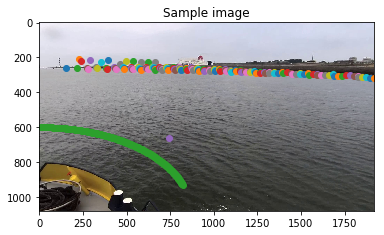

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.spatial import distance

# inladen van de image en vertalen naar een array van rgb waardes
image = Image.open('camera_3_frame_77.jpg', 'r').convert('RGB')
image_data = np.array(image.getdata()).reshape((image.height, image.width, 3))

# base parameters voor het algoritme
Y_POS = 240
X_START = 400
SAMPLE_SIZE = 8
MAX_UPPER_BOUNDY = 80
START_RADIUS = 600
X_COEFF = 1
Y_COEFF = 1.8

# vertalen van ruwe data naar een gemiddelde door de sample te slicen, en de mean van de waars
def get_average(data, x, y, size):
    start_x = max(int(y - size / 2), 0)
    start_y = max(int(x - size / 2), 0)
    end_x = min(int(y + size / 2), data.shape[1])
    end_y = min(int(x + size / 2), data.shape[1])
    samples = data[start_x:end_x, start_y:end_y]
    sample_stream = samples.transpose(2, 0, 1).reshape(3, -1)
    return np.mean(sample_stream, axis=1)


# returned de baseline van een x en y coordinaat
def get_baseline(x, y, sample_size=SAMPLE_SIZE):
    return get_average(image_data, x, y, sample_size)


# begint een pixel walker op startcoordinaaten x en y met een rigtingscooficient
def pixel_walker(x, y, rc):
    # aan het begin is er nog geen scheiding tussen water en land
    boundary = None
    # start waardes voor de walker
    delta_x = 0
    a = y
    baseline = get_baseline(x, y)
    # plt.scatter(x, y)
    # zolang er geen scheiding tussen water en land is loop de walker verder
    while not boundary:
        # bereken de huidige x positie
        # door de begin x bij de uitkomst van
        # het product met de richtingscooficient
        x_pos = (x + delta_x)

        # als de walker buiten de image valt break uit de while loop
        if x_pos > image.width or y < 0:
            break

        # bereken de euclidean distance
        average = get_average(image_data, x_pos, y, SAMPLE_SIZE)
        euclidean_distance = distance.euclidean(average, baseline)

        # als de euclidean distance groter is dan de voraf gezette boundary
        # word boundary gezet en stopt de loop bij de volgende iteratie
        if euclidean_distance > MAX_UPPER_BOUNDY:
            boundary = [x_pos, y]
            plt.scatter(x_pos, y)

        # gebruik de vorige baseline voor de volgende iteratie
        baseline = get_baseline(x_pos, y)
        delta_x = delta_x + 20
        y = a + -rc * delta_x

    return boundary


# loop die loopt van pos 400x300 naar 200x300
euclidean_distances = []
x_extended_boundy = []

# plt.imshow(image_data, aspect='auto')
plt.title('Sample image')
plt.margins(x=0, y=0)

# bereken de hoeken van 0.1 tot 1/2 pi
angle = np.arange(0.01, math.pi / 2.5, 0.005)
rc = [math.tan(a) for a in angle]
rc.reverse()
radius = image.height - START_RADIUS

cos_starting_points = np.array([math.cos(a) for a in angle])
sin_starting_points = np.array([math.sin(a) for a in angle])
start_points = np.array([radius * X_COEFF * cos_starting_points, radius * Y_COEFF * sin_starting_points])
# transleer de y waardes van de start posities
start_points[0] = image.height - start_points[0]
start_points = start_points.transpose()

bounderys = []
for i in range(len(start_points)):
    bounds = pixel_walker(start_points[i][1], start_points[i][0], rc[i])
    if bounds:
        bounderys.append(bounds)

bounderys = np.array(bounderys).transpose()
start_points = start_points.transpose()
plt.scatter(start_points[1], start_points[0])
plt.imshow(image_data)
plt.show()
plt.close()
